# Data Wrangling Notebook
The objective of this notebook is to examine and curate features from the HHS Hospital Capacity dataset (COVID-19 Reported Patient Impact and Hospital Capacity by State) in order to support downstream modeling of hospital surge stress.

The raw dataset contains 134 features, many of which relate to:

- Hospital reporting coverage
- Treatment inventories and therapeutics
- Intermediate calculation fields
- Administrative metadata

These features are not directly relevant to the project’s analytical objective are excluded.

From an operational perspective, surge risk is reflected in how hospital resources are stressed relative to demand, rather than in raw counts alone. Accordingly, this notebook focuses on identifying and retaining features that capture:

- Incoming demand (daily admissions)
- Current demand (hospitalized patient counts)
- Hospital load (beds in use)
- ICU stress, expressed through a utilization-based target variable

# Exploratory Analysis Approach

Exploratory Data Analysis (EDA) in this notebook is purpose-driven and diagnostic, rather than exhaustive. Time-series visualization is used to:

- Validate each variable behaves consistently with its intended operational role (capacity, demand, load, or utilization)
- Assess temporal relationships and lag structure between admissions, hospitalizations, and ICU utilization,
- Detect inconsistencies or misleading comparisons arising from mismatched scopes (e.g., inpatient vs ICU).

EDA is performed primarily through time-series plots, including:

- Individual feature trajectories to understand long-term behavior,
- Standardized overlays of related variables to assess co-movement and lead–lag relationships.

These visualizations inform feature selection, aggregation decisions (SUM vs MAX), and target definition, and are not intended to serve as final analytical results.

## Import Libraries

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

# Now you can import from reader
from src.data_reader.get_hhs_data import retrieve_hhs_daily_data, get_hhs_metadata
from src.schema.handle_schema import apply_schema_types
from typing import Dict, Iterable, Set, Union

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_colwidth', None)

## Load Data
Query Socrata Open Data API (SODA) to get metadata and hhs data used for tyhis project
This is the API used by healthdata.gov 

In [2]:
hhs_metadata = get_hhs_metadata()
hhs_df = retrieve_hhs_daily_data()

In [3]:
hhs_metadata[hhs_metadata.name == 'inpatient_bed_covid_utilization']

,name,type,description
48,inpatient_bed_covid_utilization,number,"49. Percentage of total (used/available) inpatient beds currently utilized by patients who have suspected or confirmed COVID-19 in this state. This number only accounts for hospitals in the state that report both ""inpatient_beds_used_covid"" and ""inpatient_beds"" fields."


In [4]:
hhs_df.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses,on_hand_supply_therapeutic_b_bamlanivimab_courses,previous_week_therapeutic_a_casirivimab_imdevimab_courses_used,previous_week_therapeutic_b_bamlanivimab_courses_used,on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses,previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_0_4,previous_day_admission_pediatric_covid_confirmed_12_17,previous_day_admission_pediatric_covid_confirmed_5_11
0,CA,2020-10-16T00:00:00.000,55,332,17,74,311,19,17,394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA,2020-10-17T00:00:00.000,56,331,17,74,312,18,16,394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA,2020-10-18T00:00:00.000,60,326,17,75,310,18,13,392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA,2020-10-19T00:00:00.000,60,328,19,78,309,20,10,398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA,2020-10-20T00:00:00.000,59,325,20,71,312,21,14,396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
hhs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Columns: 134 entries, state to previous_day_admission_pediatric_covid_confirmed_5_11
dtypes: object(134)
memory usage: 1.3+ MB


## Fix columns types
We get each column's datatype using schema retrieved and apply it to respective columns.

In [6]:
hhs_df = apply_schema_types(hhs_df)

In [7]:
hhs_df['date'].dtype

dtype('<M8[ns]')

In [8]:
# Set date as index
hhs_df = hhs_df.set_index('date')

In [9]:
hhs_df.head()

,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,...,on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses,on_hand_supply_therapeutic_b_bamlanivimab_courses,previous_week_therapeutic_a_casirivimab_imdevimab_courses_used,previous_week_therapeutic_b_bamlanivimab_courses_used,on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses,previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_0_4,previous_day_admission_pediatric_covid_confirmed_12_17,previous_day_admission_pediatric_covid_confirmed_5_11
date,,,,,,,,,,,,,,,,,,,,,
2020-10-16,CA,55.0,332.0,17.0,74.0,311.0,19.0,17.0,394.0,64536.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-10-17,CA,56.0,331.0,17.0,74.0,312.0,18.0,16.0,394.0,64028.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-10-18,CA,60.0,326.0,17.0,75.0,310.0,18.0,13.0,392.0,63898.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-10-19,CA,60.0,328.0,19.0,78.0,309.0,20.0,10.0,398.0,62967.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-10-20,CA,59.0,325.0,20.0,71.0,312.0,21.0,14.0,396.0,74167.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Dropped Features

Using the published dataset schema, each feature was reviewed to understand its definition, aggregation logic, reporting scope, and temporal characteristics.

This review enabled us to distinguish between variables that are analytically relevant to surge stress modeling and those that are not.

#### Coverage columns

Coverage columns report the number of hospitals submitting data for a given metric on each reporting day. These fields reflect data completeness and reporting participation, rather than patient demand, hospital load, utilization, or operational capacity.

Because coverage values capture reporting mechanics rather than healthcare system behavior, they were excluded from the analysis and retained only conceptually for data quality checks during exploratory review.

In [10]:
coverage_cols = [col for col in hhs_df.columns if 'coverage' in col.lower()]

In [11]:
len(coverage_cols)

55

#### Treatment Utilization and Lagging Outcome Columns

Treatment utilization and mortality-related columns capture downstream responses and outcomes that occur after periods of elevated hospital or ICU stress. These features include measures of therapeutic usage, hospital-onset events, and mortality, which reflect the consequences of surge conditions rather than their underlying drivers.

Because the objective of this project is to anticipate ICU stress, not to model clinical outcomes or treatment effects, these variables were excluded. Including them would introduce temporal leakage and violate causal ordering by allowing downstream effects to inform predictions of current or future utilization.

Accordingly, treatment utilization and lagging outcome columns are intentionally omitted from the modeling dataset.

In [12]:
post_stress_outcomes_cols = ['hospital_onset_covid', 'deaths_covid', 'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses', 
                           'on_hand_supply_therapeutic_b_bamlanivimab_courses', 
                           'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses', 
                           'previous_week_therapeutic_a_casirivimab_imdevimab_courses_used', 
                           'previous_week_therapeutic_b_bamlanivimab_courses_used', 
                           'previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used', 
                           'previous_day_deaths_covid_and_influenza', 
                           'previous_day_deaths_influenza']

#### Numerator and denominator components

Numerator and denominator components are raw count fields used to construct utilization and percentage-based metrics. When the derived utilization metric is used as the target variable, including its underlying components as predictors would introduce mechanical leakage, allowing the model to trivially reconstruct the target rather than learn meaningful relationships from upstream demand signals.

Because this project models ICU stress through a utilization-based target, these component variables were excluded to preserve causal integrity and ensure that predictive performance reflects genuine explanatory signal rather than arithmetic reconstruction.

In [13]:
num_denom_vars = ['inpatient_beds_utilization_numerator', 'inpatient_beds_utilization_denominator', 
                  'percent_of_inpatients_with_covid_numerator', 'percent_of_inpatients_with_covid_denominator', 
                  'inpatient_bed_covid_utilization_numerator', 'inpatient_bed_covid_utilization_denominator', 
                   'adult_icu_bed_covid_utilization_numerator', 'adult_icu_bed_covid_utilization_denominator', 
                  'adult_icu_bed_utilization_numerator', 'adult_icu_bed_utilization_denominator']


#### Age-group specific breakdowns(Reporting noise)

Age-group–specific admission and hospitalization columns provide disaggregated views of patient counts by demographic category. While clinically informative, these fields do not introduce additional signal for modeling system-level surge stress, as aggregated admission and hospitalization counts already capture overall demand pressure on hospital resources.

Including age-level breakdowns would increase feature dimensionality and sensitivity to reporting variability without materially improving predictive power for ICU utilization. These columns were therefore excluded to reduce noise and maintain a parsimonious, system-focused feature set.

In [14]:
age_div_vars = ['previous_day_admission_adult_covid_confirmed_18_19', 'previous_day_admission_adult_covid_confirmed_20_29', 
                'previous_day_admission_adult_covid_confirmed_30_39', 'previous_day_admission_adult_covid_confirmed_40_49', 
                'previous_day_admission_adult_covid_confirmed_50_59', 'previous_day_admission_adult_covid_confirmed_60_69', 
                'previous_day_admission_adult_covid_confirmed_70_79', 'previous_day_admission_adult_covid_confirmed_80', 
                'previous_day_admission_adult_covid_confirmed_unknown', 'previous_day_admission_adult_covid_suspected_18_19', 
                'previous_day_admission_adult_covid_suspected_20_29', 'previous_day_admission_adult_covid_suspected_30_39', 
                'previous_day_admission_adult_covid_suspected_40_49', 'previous_day_admission_adult_covid_suspected_50_59', 
                'previous_day_admission_adult_covid_suspected_60_69', 'previous_day_admission_adult_covid_suspected_70_79', 
                'previous_day_admission_adult_covid_suspected_80_', 'previous_day_admission_adult_covid_suspected_unknown', 
                'previous_day_admission_pediatric_covid_confirmed_0_4', 'previous_day_admission_pediatric_covid_confirmed_12_17', 
                'previous_day_admission_pediatric_covid_confirmed_5_11', 'previous_day_admission_pediatric_covid_confirmed_unknown']


#### Administrative post-stress responses

Administrative post-stress response columns capture operational or reporting actions taken by hospitals in response to elevated stress, such as emergency declarations, policy flags, or administrative status indicators. These variables do not reflect underlying patient demand or disease burden, but rather institutional reactions to conditions that have already occurred.

Because these features are reactive rather than causal, they are not appropriate inputs for a forward-looking surge prediction task. Including them would risk conflating response signals with demand drivers and introduce temporal leakage. As a result, administrative post-stress response columns were excluded from the analysis.

In [15]:
metadata_cols = ':@computed_region_pqdx_y6mm'

human_post_stress_responses = ['critical_staffing_shortage_today_yes',
                               'critical_staffing_shortage_today_no',
                               'critical_staffing_shortage_today_not_reported',
                               'critical_staffing_shortage_anticipated_within_week_yes',
                               'critical_staffing_shortage_anticipated_within_week_no',
                               'critical_staffing_shortage_anticipated_within_week_not_reported']

#### ICU Occupancy

ICU occupancy count variables were excluded because they are direct components of the utilization target, and including them as predictors would introduce mechanical leakage, allowing the model to reconstruct utilization rather than learn from upstream demand signals.

In addition, ICU capacity-related fields (e.g., total_staffed_pediatric_icu_beds) represent capacity constraints that influence utilization but are not driven by short-term patient demand. Exploratory analysis revealed regime changes in reporting and structural shifts over time for these variables, indicating that they would require explicit temporal stratification or regime-aware modeling.

To avoid leakage and prevent misinterpretation arising from unmodeled regime changes, ICU occupancy and capacity columns are excluded from the Version 1 modeling dataset and reserved for potential inclusion in future extensions focused on capacity dynamics.

In [16]:
icu_occupancy = ['staffed_icu_adult_patients_confirmed_and_suspected_covid', 'staffed_icu_adult_patients_confirmed_covid',
                'staffed_icu_pediatric_patients_confirmed_covid', 'total_staffed_pediatric_icu_beds', 'percent_of_inpatients_with_covid',
                'staffed_adult_icu_bed_occupancy', 'total_staffed_adult_icu_beds']

#### Broader Outcome variable
'adult_icu_bed_utilization' measures overall adult ICU utilization across all causes, reflecting total ICU demand relative to staffed adult ICU capacity.

In [17]:
not_v1 = 'adult_icu_bed_utilization'

#### Pediatric covid incoming, hospitalizations, capacity counts

Pediatric COVID admission, hospitalization, and capacity variables were excluded because they are not primary drivers of adult ICU COVID utilization, which is the Version 1 modeling target. While pediatric hospitalizations may contribute indirectly to system-wide staffing or bed competition, these effects are second-order and not directly aligned with adult ICU stress dynamics.

In addition, pediatric capacity metrics represent a separate care pathway with distinct staffing, bed allocation, and clinical thresholds, making them poorly matched to an adult ICU utilization target. Incoming pediatric admission signals were also found to add variability without a clear or consistent lead–lag relationship to adult ICU utilization.

To maintain scope alignment and reduce noise, pediatric COVID-related features were excluded from the Version 1 feature set.

In [18]:
pediatric_covid_cols = ['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid', 
                        'total_pediatric_patients_hospitalized_confirmed_covid',
                        'all_pediatric_inpatient_beds',
                        'previous_day_admission_pediatric_covid_confirmed',
                        'previous_day_admission_pediatric_covid_suspected',
                        'staffed_pediatric_icu_bed_occupancy']

#### Inpatient bed utilization

Inpatient bed utilization variables aggregate heterogeneous patient populations, including medical, surgical, elective, trauma, and non-respiratory cases, many of which are not explicitly observed or disaggregated within the dataset. As a result, these measures conflate respiratory-driven demand with unrelated hospital activity.

Because the modeling objective is to predict adult ICU COVID utilization, this aggregation introduces noise and obscures the causal relationship between respiratory admissions and ICU stress. Including inpatient bed utilization would therefore reduce interpretability and dilute the signal relevant to the target. These variables were excluded to maintain focus on demand pathways that are directly aligned with adult ICU COVID dynamics.

In [19]:
inpatient_beds_occupancy = ['inpatient_beds_used', 'all_pediatric_inpatient_bed_occupied', 'inpatient_beds_utilization', 
                            'inpatient_beds', 'inpatient_bed_covid_utilization']

#### Redundant driver
This variable is a subset of two signals we already include: COVID hospitalizations and Influenza hospitalizations

In [20]:
redundant_driver = 'total_patients_hospitalized_confirmed_influenza_and_covid'

In [21]:
COLUMN_GROUPS = {
    # "metadata": metadata_cols,
    "coverage": coverage_cols,
    "outcomes": post_stress_outcomes_cols,
    "num_denom_components": num_denom_vars,
    "age_stratified": age_div_vars,
    "post_stress": human_post_stress_responses,
    "icu_occupancy": icu_occupancy,
    "not_included_for_v1": not_v1,
    "pediatric_cols": pediatric_covid_cols,
    "inpatient_bed_utilization": inpatient_beds_occupancy,
    "irrelevant": redundant_driver
}

In [22]:
def flatten_column_names_lists(column_groups: Dict[str, Union[str, Iterable[str]]]) -> Set[str]:
    """
    Flattens a dictionary of column groups into a single set of column names.
    
    Values may be a single column name (str) or an iterable of column names.
    """
    if not column_groups:
        raise ValueError("No column groups provided")

    all_cols_to_drop: Set[str] = set()

    for v in column_groups.values():
        if isinstance(v, str):
            all_cols_to_drop.add(v)
        elif isinstance(v, Iterable):
            all_cols_to_drop.update(v)
        else:
            raise TypeError(f"Unexpected column group type: {type(v)}")

    return list(all_cols_to_drop)


In [23]:
all_cols_to_drop = flatten_column_names_lists(COLUMN_GROUPS)

In [24]:
print(f"We are dropping {len(all_cols_to_drop)} columns from the original dataset")

We are dropping 123 columns from the original dataset


In [25]:
hhs_df = hhs_df.drop(columns=all_cols_to_drop)

In [26]:
hhs_df.head()

,state,inpatient_beds_used_covid,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_suspected,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,adult_icu_bed_covid_utilization,icu_patients_confirmed_influenza,previous_day_admission_influenza_confirmed,total_patients_hospitalized_confirmed_influenza
date,,,,,,,,,,
2020-10-16,CA,3146.0,332.0,511.0,3106.0,2256.0,0.104452,0.0,0.0,0.0
2020-10-17,CA,3076.0,337.0,448.0,3050.0,2223.0,0.102779,0.0,0.0,0.0
2020-10-18,CA,3154.0,314.0,456.0,3118.0,2269.0,0.107879,0.0,0.0,0.0
2020-10-19,CA,3225.0,316.0,474.0,3092.0,2311.0,0.111332,4.0,0.0,24.0
2020-10-20,CA,3084.0,366.0,487.0,3041.0,2363.0,0.10653,7.0,1.0,32.0


## Feature Evaluation

We choose the target below ICU utilization, not raw counts, beacuse it triggers action in hospitals. 

    Qn: How close are we to exhausting ICU capacity?

This makes it a decision outcome.

In [27]:
target = 'adult_icu_bed_covid_utilization'

These columns measure new patient admissions reported on the previous day, representing incoming demand flowing into the hospital system for COVID (adult, confirmed and suspected) and influenza.

In [28]:
incoming_demand = ['previous_day_admission_adult_covid_confirmed', 
                   'previous_day_admission_adult_covid_suspected', 
                   'previous_day_admission_influenza_confirmed']

These columns represent current hospitalized patient counts, capturing the accumulated demand already present in the healthcare system at a given point in time. They include adult and pediatric COVID hospitalizations (confirmed and suspected) as well as influenza-related hospitalizations, reflecting the existing patient load that may progress to ICU care.

In [29]:
current_demand_stock_cols = ['total_adult_patients_hospitalized_confirmed_and_suspected_covid', 
                            'total_adult_patients_hospitalized_confirmed_covid', 
                            'total_patients_hospitalized_confirmed_influenza']

These columns measure inpatient bed occupancy levels, reflecting how many staffed inpatient beds are currently occupied overall.

In [30]:
inpatient_bed_covid_occupancy = ['inpatient_beds_used_covid']

'icu_patients_confirmed_influenza' captures concurrent ICU demand from influenza, representing cross-disease competition for ICU capacity that can elevate ICU utilization even when COVID admissions are modest

In [31]:
icu_competition_demand = 'icu_patients_confirmed_influenza'

In [32]:
RETAINED_COLUMN_GROUPS = {
    "state": 'state',
    "stress_indicator": target,
    "demand": incoming_demand,
    "current_system_load": current_demand_stock_cols,
    "covid_bed_utilization": inpatient_bed_covid_occupancy,
    "icu_demand_competition": icu_competition_demand
}

In [33]:
all_cols_to_retain = flatten_column_names_lists(RETAINED_COLUMN_GROUPS)

In [34]:
print(f"Keeping {len(all_cols_to_retain)} columns from original dataset")

Keeping 10 columns from original dataset


In [35]:
hhs_retained = hhs_df[all_cols_to_retain].copy()

In [36]:
hhs_retained.describe().T

,count,mean,std,min,25%,50%,75%,max
inpatient_beds_used_covid,1290.0,4001.116279,4305.291106,650.0,1434.0,2474.0,4446.0,30334.0
total_patients_hospitalized_confirmed_influenza,1290.0,171.562016,330.824425,0.0,30.0,49.0,140.0,2163.0
previous_day_admission_adult_covid_suspected,1290.0,302.388372,153.034353,36.0,160.0,321.0,406.0,694.0
previous_day_admission_influenza_confirmed,1290.0,31.306202,67.99692,0.0,3.0,7.0,22.0,527.0
icu_patients_confirmed_influenza,1290.0,22.009302,44.520268,0.0,2.0,6.0,17.0,271.0
previous_day_admission_adult_covid_confirmed,1290.0,492.727907,456.507103,74.0,229.25,353.5,543.0,2550.0
total_adult_patients_hospitalized_confirmed_and_suspected_covid,1290.0,3909.382946,4251.433156,628.0,1389.5,2409.5,4298.75,30134.0
total_adult_patients_hospitalized_confirmed_covid,1290.0,3665.346512,4119.139947,459.0,1378.25,2289.5,3934.75,29553.0
adult_icu_bed_covid_utilization,1290.0,0.104991,0.116496,0.016535,0.037048,0.053707,0.129728,0.553731


## Influenza

Question: What does influenza hospitalization and ICU demand look like over  time?

Features: 'previous_day_admission_influenza_confirmed', 'total_patients_hospitalized_confirmed_influenza', 'icu_patients_confirmed_influenza', 

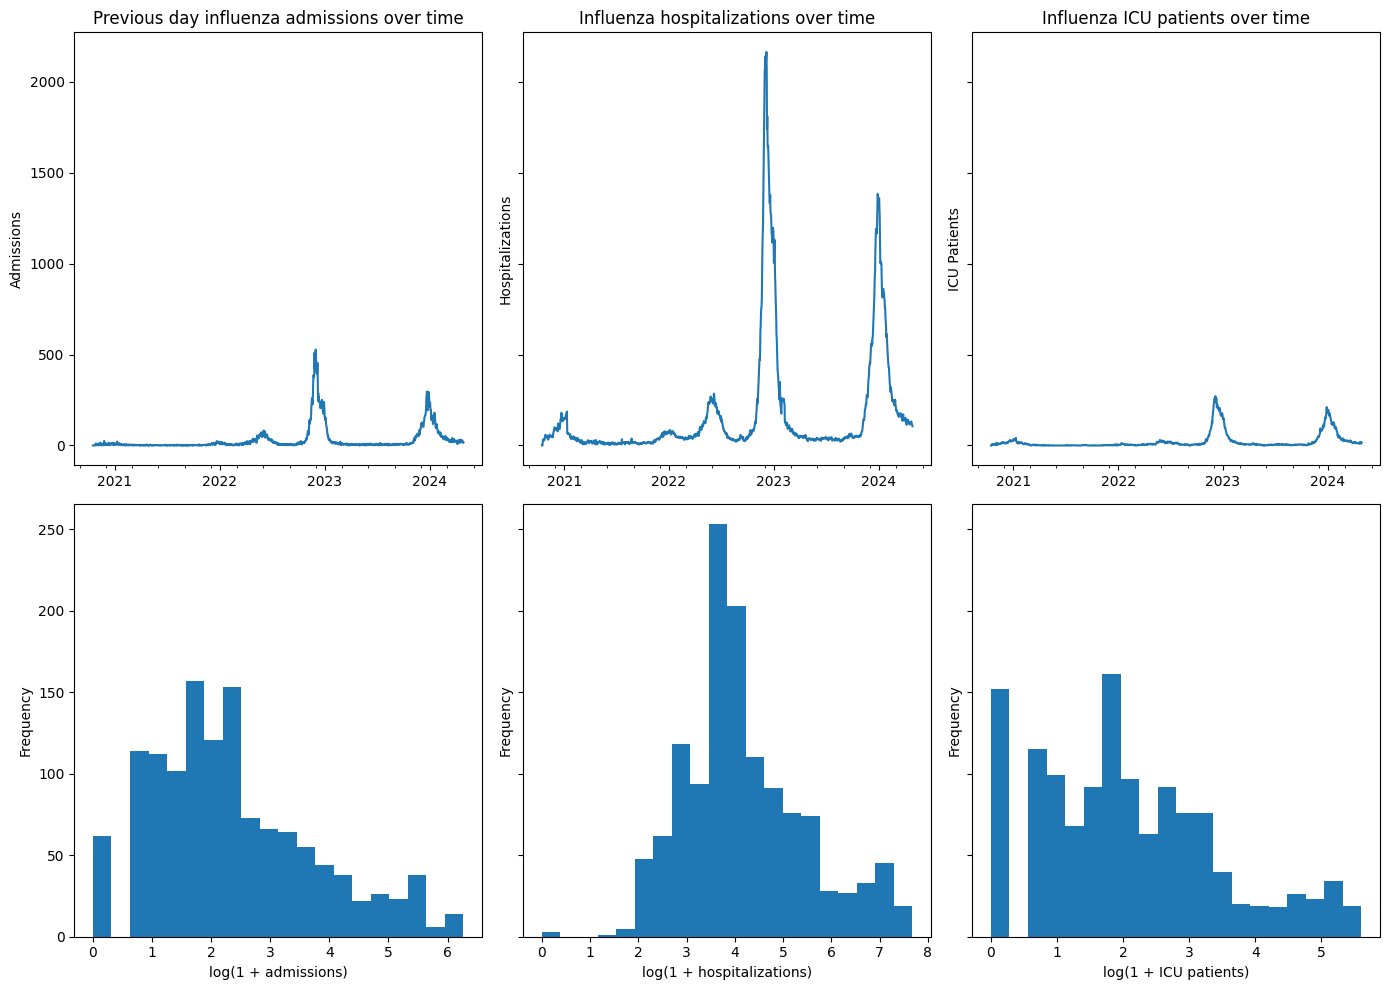

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10), sharey='row')

# Top-left: Influenza admissions over time
axes[0, 0].plot(hhs_retained['previous_day_admission_influenza_confirmed'])
axes[0, 0].set_title("Previous day influenza admissions over time")
axes[0, 0].set_ylabel("Admissions")

# Top-middle: Influenza hospitalizations over time
axes[0, 1].plot(hhs_retained['total_patients_hospitalized_confirmed_influenza'])
axes[0, 1].set_title("Influenza hospitalizations over time")
axes[0, 1].set_ylabel("Hospitalizations")

# Top-right: Influenza ICU patients over time
axes[0, 2].plot(hhs_retained['icu_patients_confirmed_influenza'])
axes[0, 2].set_title("Influenza ICU patients over time")
axes[0, 2].set_ylabel("ICU Patients")

# Apply consistent date formatting to top row
for ax in axes[0]:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Bottom-left: Histogram (log1p) of previous admissions
axes[1, 0].hist(np.log1p(hhs_retained['previous_day_admission_influenza_confirmed']), bins=20)
axes[1, 0].set_xlabel("log(1 + admissions)")
axes[1, 0].set_ylabel("Frequency")

# Bottom-middle: Histogram (log1p) of hospitalizations
axes[1, 1].hist(np.log1p(hhs_retained['total_patients_hospitalized_confirmed_influenza']), bins=20)
axes[1, 1].set_xlabel("log(1 + hospitalizations)")
axes[1, 1].set_ylabel("Frequency")

# Bottom-right: Histogram (log1p) of ICU patients
axes[1, 2].hist(np.log1p(hhs_retained['icu_patients_confirmed_influenza']), bins=20)
axes[1, 2].set_xlabel("log(1 + ICU patients)")
axes[1, 2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


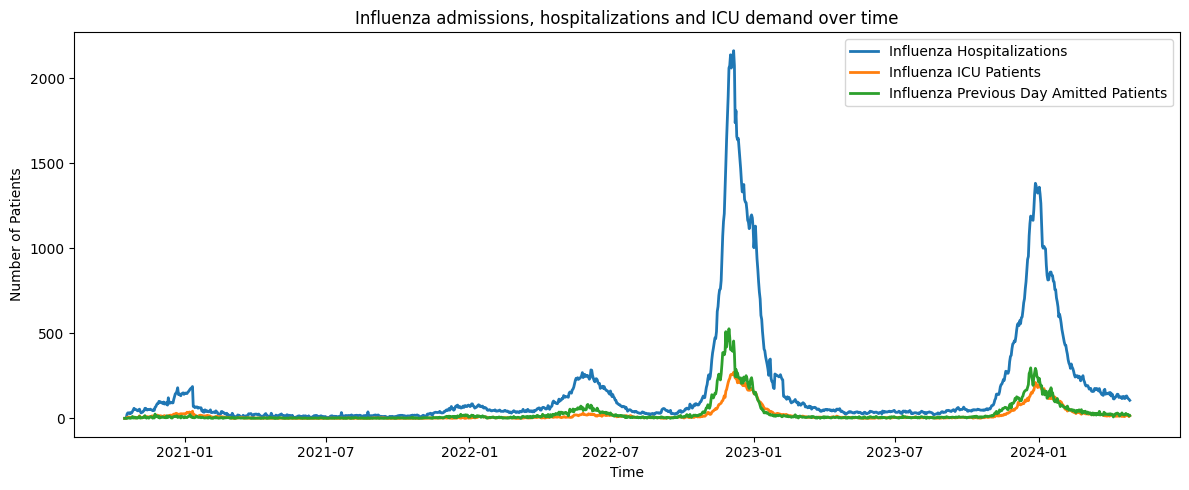

In [38]:
plt.figure(figsize=(12, 5))

plt.plot(hhs_retained['total_patients_hospitalized_confirmed_influenza'], label='Influenza Hospitalizations', linewidth=2)
plt.plot(hhs_retained['icu_patients_confirmed_influenza'], label='Influenza ICU Patients', linewidth=2)
plt.plot(hhs_retained['previous_day_admission_influenza_confirmed'], label='Influenza Previous Day Amitted Patients', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Number of Patients")
plt.title("Influenza admissions, hospitalizations and ICU demand over time")
plt.legend()
plt.tight_layout()
plt.show()


Log-scaled distributions are used because influenza admissions, hospitalizations, and ICU counts are highly right-skewed, with many days of very low activity punctuated by short, intense seasonal surges. The log(1+x) transformation compresses extreme peaks while preserving relative differences, allowing both low-activity baseline periods and high-demand seasons to be visualized and compared meaningfully. 

When interpreted alongside the time-series plot, the distributions confirm that influenza demand propagates in an ordered manner from admissions to hospitalizations and then to ICU demand, rather than appearing as isolated ICU shocks. This combined view distinguishes periods of minimal influenza activity from sustained seasonal pressure and supports interpreting influenza as a persistent background contributor to hospital and ICU load with predictable seasonal amplification.

## Covid Incoming Adult Hospitalizations(Incoming Demand)

Question: What does incoming adult COVID demand look like over time, and how do confirmed and suspected admission counts relate?

Features: 'previous_day_admission_adult_covid_confirmed', 'previous_day_admission_adult_covid_suspected'

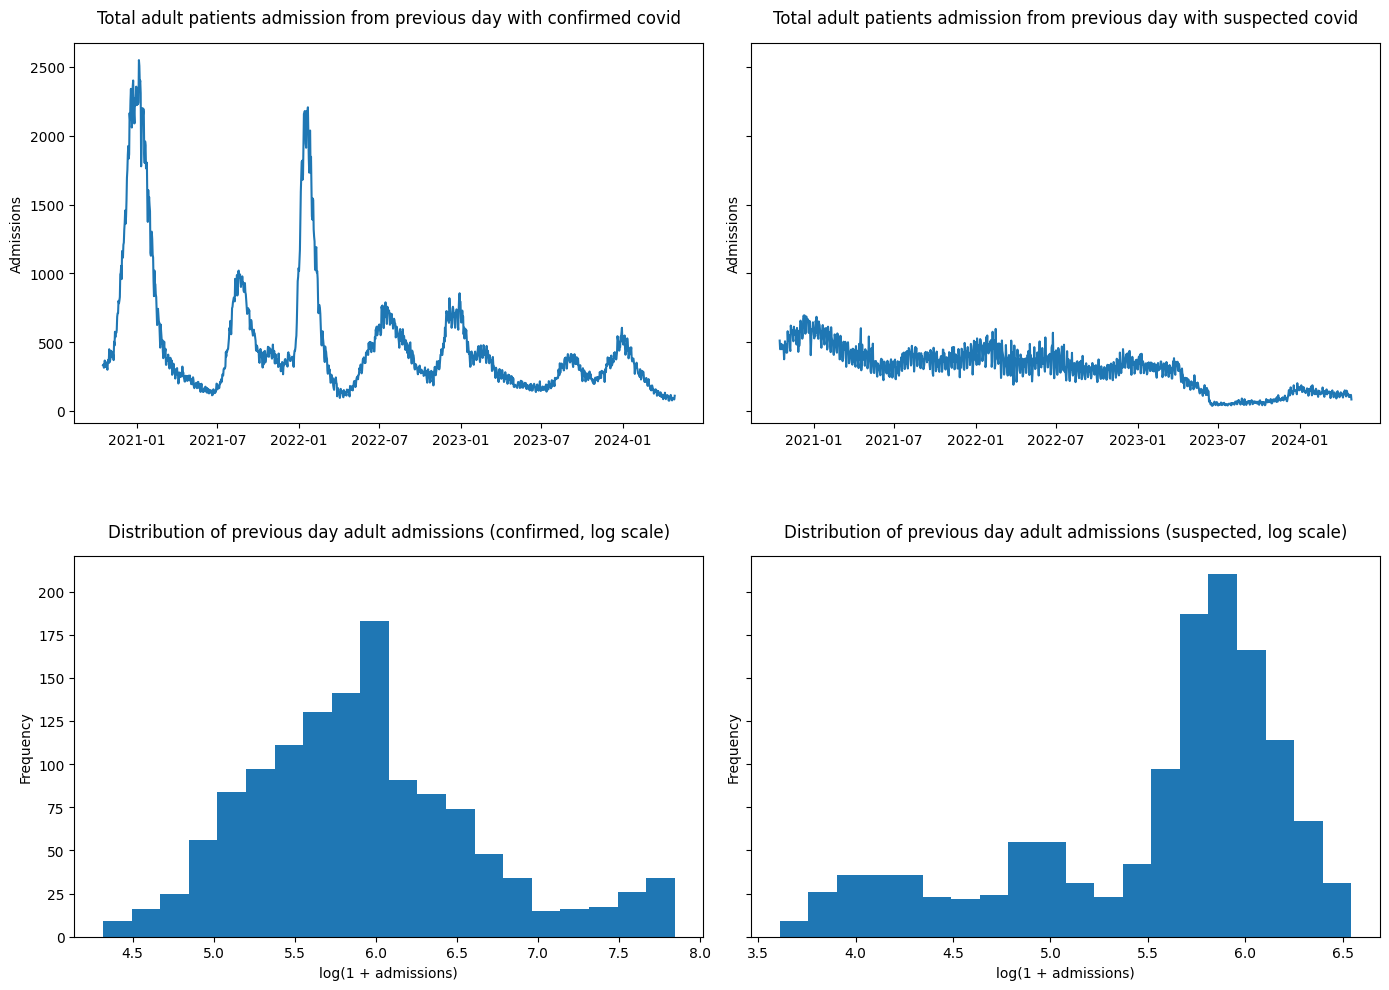

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey='row')

# Top-left: Confirmed covid previous day admission over time
axes[0, 0].plot(hhs_retained['previous_day_admission_adult_covid_confirmed'])
axes[0, 0].set_title("Total adult patients admission from previous day with confirmed covid", y=1.03)
axes[0, 0].set_ylabel("Admissions")

# Top-right: Suspected covid previous day admission over time
axes[0, 1].plot(hhs_retained['previous_day_admission_adult_covid_suspected'])
axes[0, 1].set_title("Total adult patients admission from previous day with suspected covid", y=1.03)
axes[0, 1].set_ylabel("Admissions")

# Bottom-left: Histogram (log1p) of previous day admissions (confirmed)
axes[1, 0].hist(np.log1p(hhs_retained['previous_day_admission_adult_covid_confirmed']), bins=20)
axes[1, 0].set_title("Distribution of previous day adult admissions (confirmed, log scale)", y=1.03)
axes[1, 0].set_xlabel("log(1 + admissions)")
axes[1, 0].set_ylabel("Frequency")

# Bottom-right: Histogram (log1p) of previous day admissions (suspected)
axes[1, 1].hist(np.log1p(hhs_retained['previous_day_admission_adult_covid_suspected']), bins=20)
axes[1, 1].set_title("Distribution of previous day adult admissions (suspected, log scale)", y=1.03)
axes[1, 1].set_xlabel("log(1 + admissions)")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()


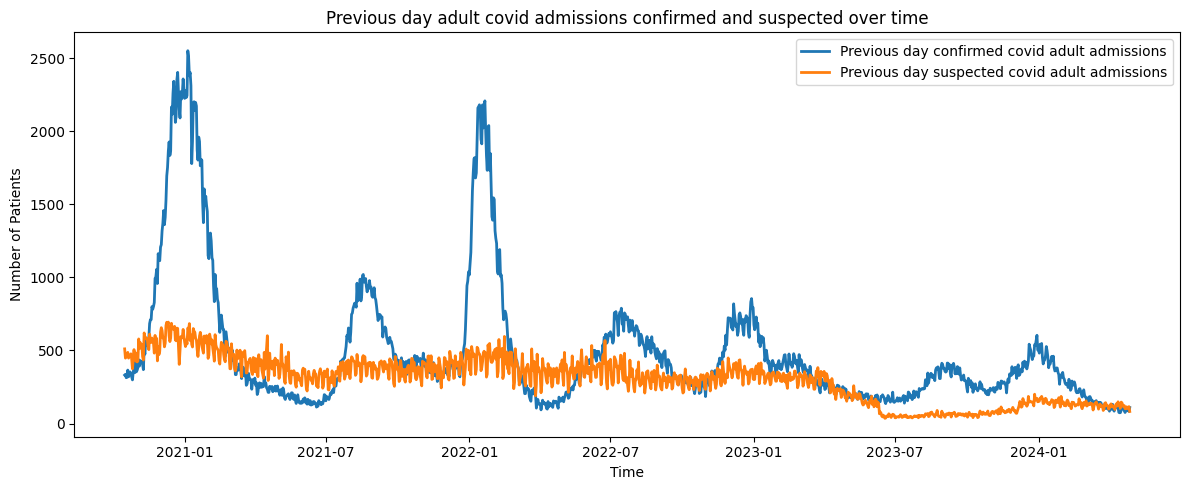

In [40]:
plt.figure(figsize=(12, 5))

plt.plot(hhs_retained['previous_day_admission_adult_covid_confirmed'], label='Previous day confirmed covid adult admissions', linewidth=2)
plt.plot(hhs_retained['previous_day_admission_adult_covid_suspected'], label='Previous day suspected covid adult admissions', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Number of Patients")
plt.title("Previous day adult covid admissions confirmed and suspected over time")
plt.legend()
plt.tight_layout()
plt.show()

Previous-day confirmed and suspected adult COVID admissions exhibit strong temporal co-movement across all major waves, with suspected admissions contributing a lower-magnitude but consistent signal. While confirmed admissions dominate peak severity, suspected admissions track the same surge timing and reflect diagnostic uncertainty during periods of elevated demand. 

This supports aggregating confirmed and suspected admissions into a single incoming-demand feature to capture total hospitalization pressure without introducing redundant or conflicting dynamics.

## Covid Adult Hospitalizations(Current Demand Stock)

Question: What does adult COVID-19 hospitalization demand look like over time?

Fetaures: 'total_adult_patients_hospitalized_confirmed_and_suspected_covid', 'total_adult_patients_hospitalized_confirmed_covid'

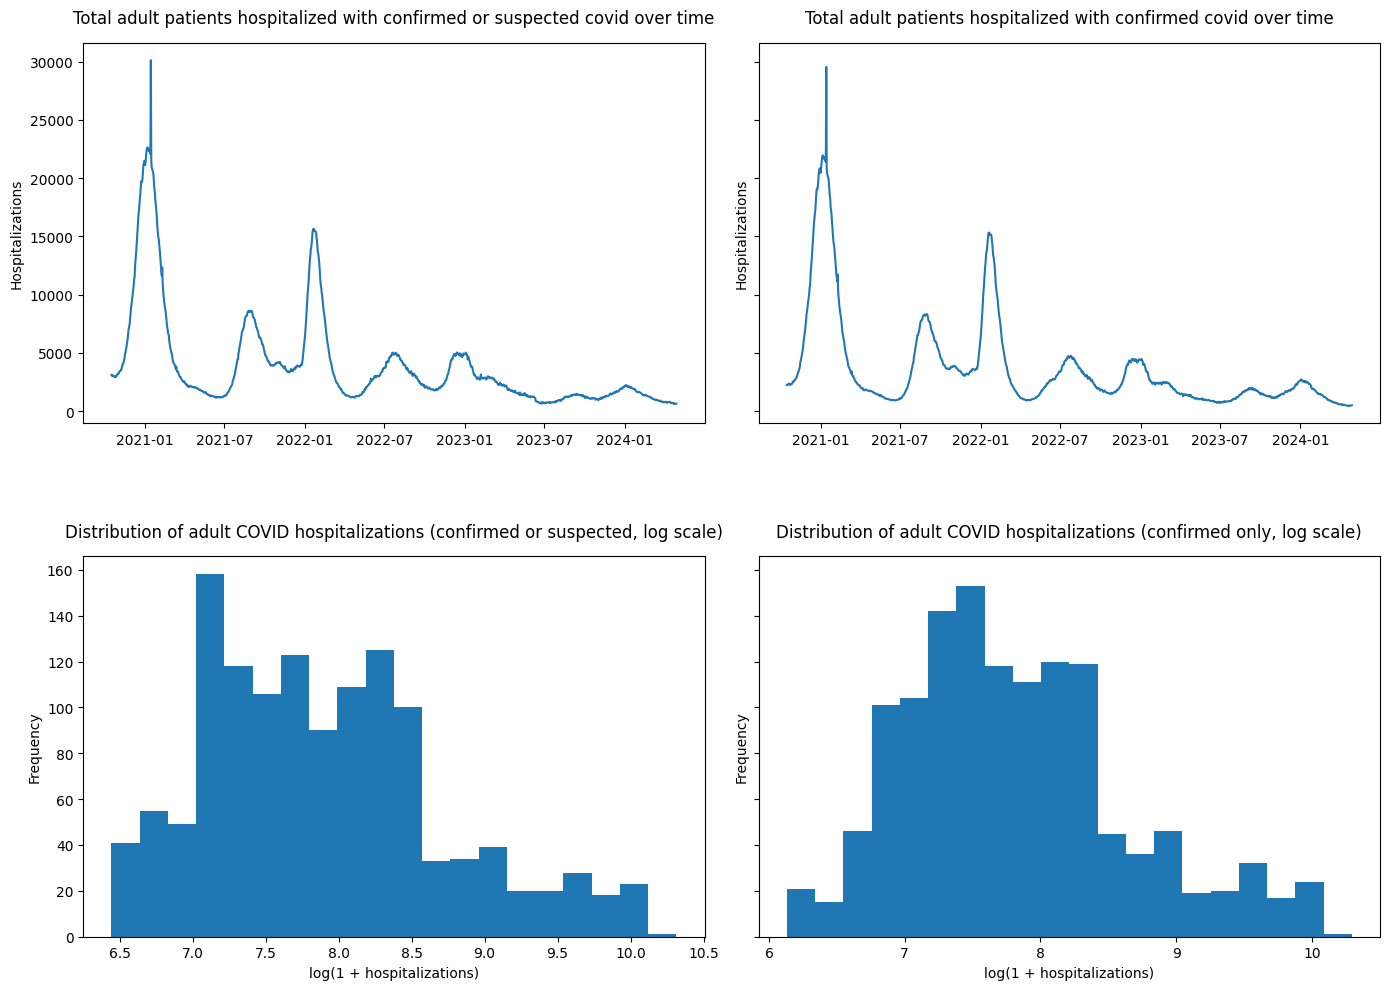

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey='row')

# Top-left: Confirmed or suspected covid total hospitalizations
axes[0, 0].plot(hhs_retained['total_adult_patients_hospitalized_confirmed_and_suspected_covid'])
axes[0, 0].set_title("Total adult patients hospitalized with confirmed or suspected covid over time", y=1.03)
axes[0, 0].set_ylabel("Hospitalizations")

# Top-right: Confirmed covid total hospitalizations
axes[0, 1].plot(hhs_retained['total_adult_patients_hospitalized_confirmed_covid'])
axes[0, 1].set_title("Total adult patients hospitalized with confirmed covid over time", y=1.03)
axes[0, 1].set_ylabel("Hospitalizations")

# Bottom-left: Histogram (log1p) of total covid hospitalizations (confirmed or suspected)
axes[1, 0].hist(np.log1p(hhs_retained['total_adult_patients_hospitalized_confirmed_and_suspected_covid']), bins=20)
axes[1, 0].set_title("Distribution of adult COVID hospitalizations (confirmed or suspected, log scale)", y=1.03)
axes[1, 0].set_xlabel("log(1 + hospitalizations)")
axes[1, 0].set_ylabel("Frequency")

# Bottom-right: Histogram (log1p) of total covid hospitalizations (confirmed)
axes[1, 1].hist(np.log1p(hhs_retained['total_adult_patients_hospitalized_confirmed_covid']), bins=20)
axes[1, 1].set_title("Distribution of adult COVID hospitalizations (confirmed only, log scale)", y=1.03)
axes[1, 1].set_xlabel("log(1 + hospitalizations)")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()


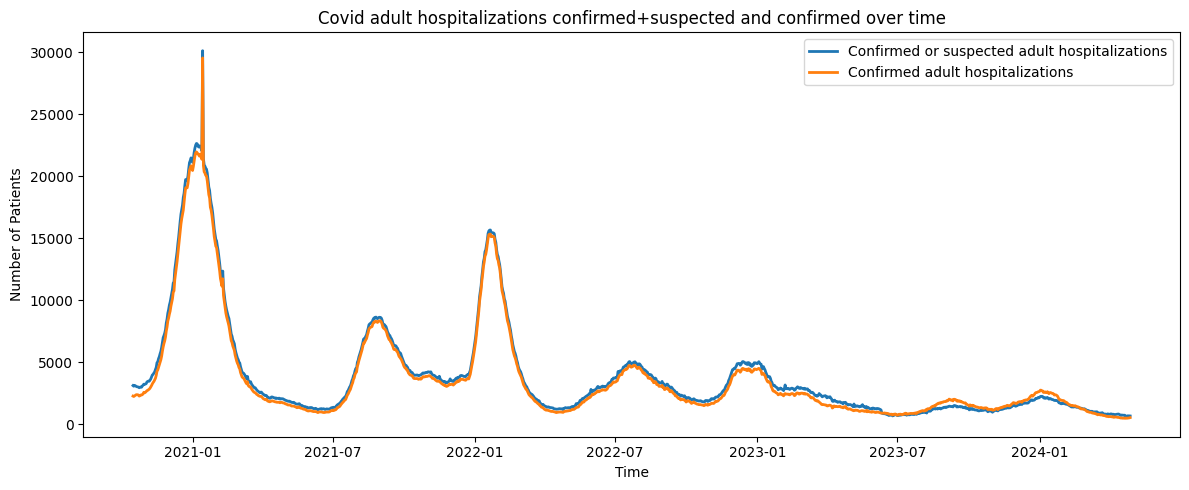

In [42]:
plt.figure(figsize=(12, 5))

plt.plot(hhs_retained['total_adult_patients_hospitalized_confirmed_and_suspected_covid'], label='Confirmed or suspected adult hospitalizations', linewidth=2)
plt.plot(hhs_retained['total_adult_patients_hospitalized_confirmed_covid'], label='Confirmed adult hospitalizations', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Number of Patients")
plt.title("Covid adult hospitalizations confirmed+suspected and confirmed over time")
plt.legend()
plt.tight_layout()
plt.show()


Confirmed-only and confirmed + suspected adult COVID hospitalizations exhibit indistinguishable temporal dynamics, supporting the use of the combined series as a complete measure of inpatient COVID demand.

For modeling, taking the maximum of the two series provides a conservative, leakage-safe estimate of realized hospitalization burden, avoids double-counting correlated signals, and ensures peak capacity pressure is not understated during periods of diagnostic uncertainty.

## Inpatient Covid Beds(Inpatient Demand)

Qn: How does inpatient hospital beds occupied by patients with COVID-19 change over time?

Features: 'inpatient_beds_used_covid'

The number of inpatient beds (non-ICU and ICU combined, unless otherwise specified) that are occupied by COVID-19 patients on a given reporting day.

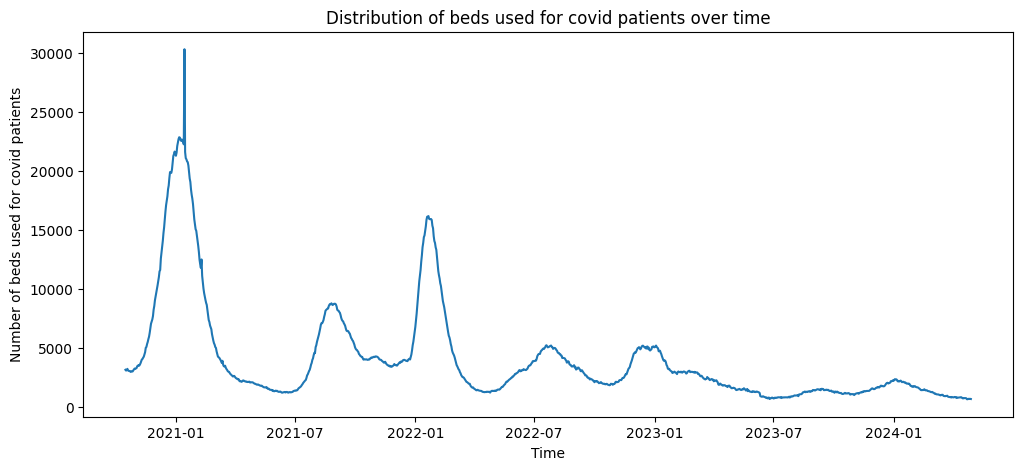

In [43]:
plt.figure(figsize=(12, 5))

plt.plot(hhs_retained['inpatient_beds_used_covid'])
plt.xlabel("Time")
plt.ylabel("Number of beds used for covid patients")
plt.title("Distribution of beds used for covid patients over time")
plt.show()


'inpatient_beds_used_covid' exhibits pronounced, wave-like surges early in the pandemic, followed by progressively smaller and shorter peaks over time. While absolute COVID inpatient demand declines in later periods, the persistence of recurring waves indicates that episodic surges remain a relevant driver of hospital load rather than a one-time shock.

## Target Feature

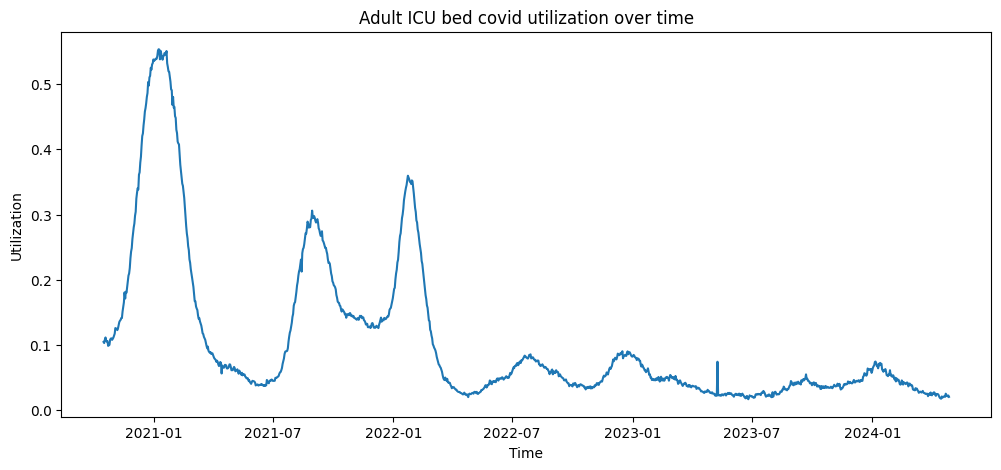

In [44]:
plt.figure(figsize=(12, 5))

plt.plot(hhs_retained['adult_icu_bed_covid_utilization'])
plt.xlabel("Time")
plt.ylabel("Utilization")
plt.title("Adult ICU bed covid utilization over time")
plt.show()


## Aggregating demand columns

- sum('previous_day_admission_adult_covid_confirmed', 'previous_day_admission_adult_covid_suspected')
- max('total_adult_patients_hospitalized_confirmed_and_suspected_covid', 'total_adult_patients_hospitalized_confirmed_covid')

In [45]:
# use total to use confirmed + suspected
previous_day_admissions_adult_covid_cols = ['previous_day_admission_adult_covid_confirmed', 'previous_day_admission_adult_covid_suspected']

hhs_retained['previous_day_admission_adult_covid_confirmed_and_suspected'] = hhs_retained['previous_day_admission_adult_covid_confirmed'] + hhs_df['previous_day_admission_adult_covid_suspected']

In [46]:
# use max between these two columns
total_adult_patients_hospitalized_cols = ['total_adult_patients_hospitalized_confirmed_and_suspected_covid', 'total_adult_patients_hospitalized_confirmed_covid']

hhs_retained['total_adult_patients_hospitalized_confirmed_and_suspected_covid_max'] = hhs_retained[total_adult_patients_hospitalized_cols].max(axis=1)

In [47]:
hhs_retained = hhs_retained.drop(columns=previous_day_admissions_adult_covid_cols)

In [48]:
hhs_cleaned = hhs_retained.drop(columns=total_adult_patients_hospitalized_cols)

In [49]:
hhs_cleaned.head()

,inpatient_beds_used_covid,total_patients_hospitalized_confirmed_influenza,previous_day_admission_influenza_confirmed,icu_patients_confirmed_influenza,adult_icu_bed_covid_utilization,state,previous_day_admission_adult_covid_confirmed_and_suspected,total_adult_patients_hospitalized_confirmed_and_suspected_covid_max
date,,,,,,,,
2020-10-16,3146.0,0.0,0.0,0.0,0.104452,CA,843.0,3106.0
2020-10-17,3076.0,0.0,0.0,0.0,0.102779,CA,785.0,3050.0
2020-10-18,3154.0,0.0,0.0,0.0,0.107879,CA,770.0,3118.0
2020-10-19,3225.0,24.0,0.0,4.0,0.111332,CA,790.0,3092.0
2020-10-20,3084.0,32.0,1.0,7.0,0.10653,CA,853.0,3041.0


In [50]:
hhs_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2020-10-16 to 2024-04-27
Data columns (total 8 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   inpatient_beds_used_covid                                            1290 non-null   Float64
 1   total_patients_hospitalized_confirmed_influenza                      1290 non-null   Float64
 2   previous_day_admission_influenza_confirmed                           1290 non-null   Float64
 3   icu_patients_confirmed_influenza                                     1290 non-null   Float64
 4   adult_icu_bed_covid_utilization                                      1290 non-null   Float64
 5   state                                                                1290 non-null   string 
 6   previous_day_admission_adult_covid_confirmed_and_suspected           1290 non-null   Fl

In [51]:
# same state for all observations, drop, not useful for downstream processes
hhs_cleaned = hhs_cleaned.drop('state', axis=1)

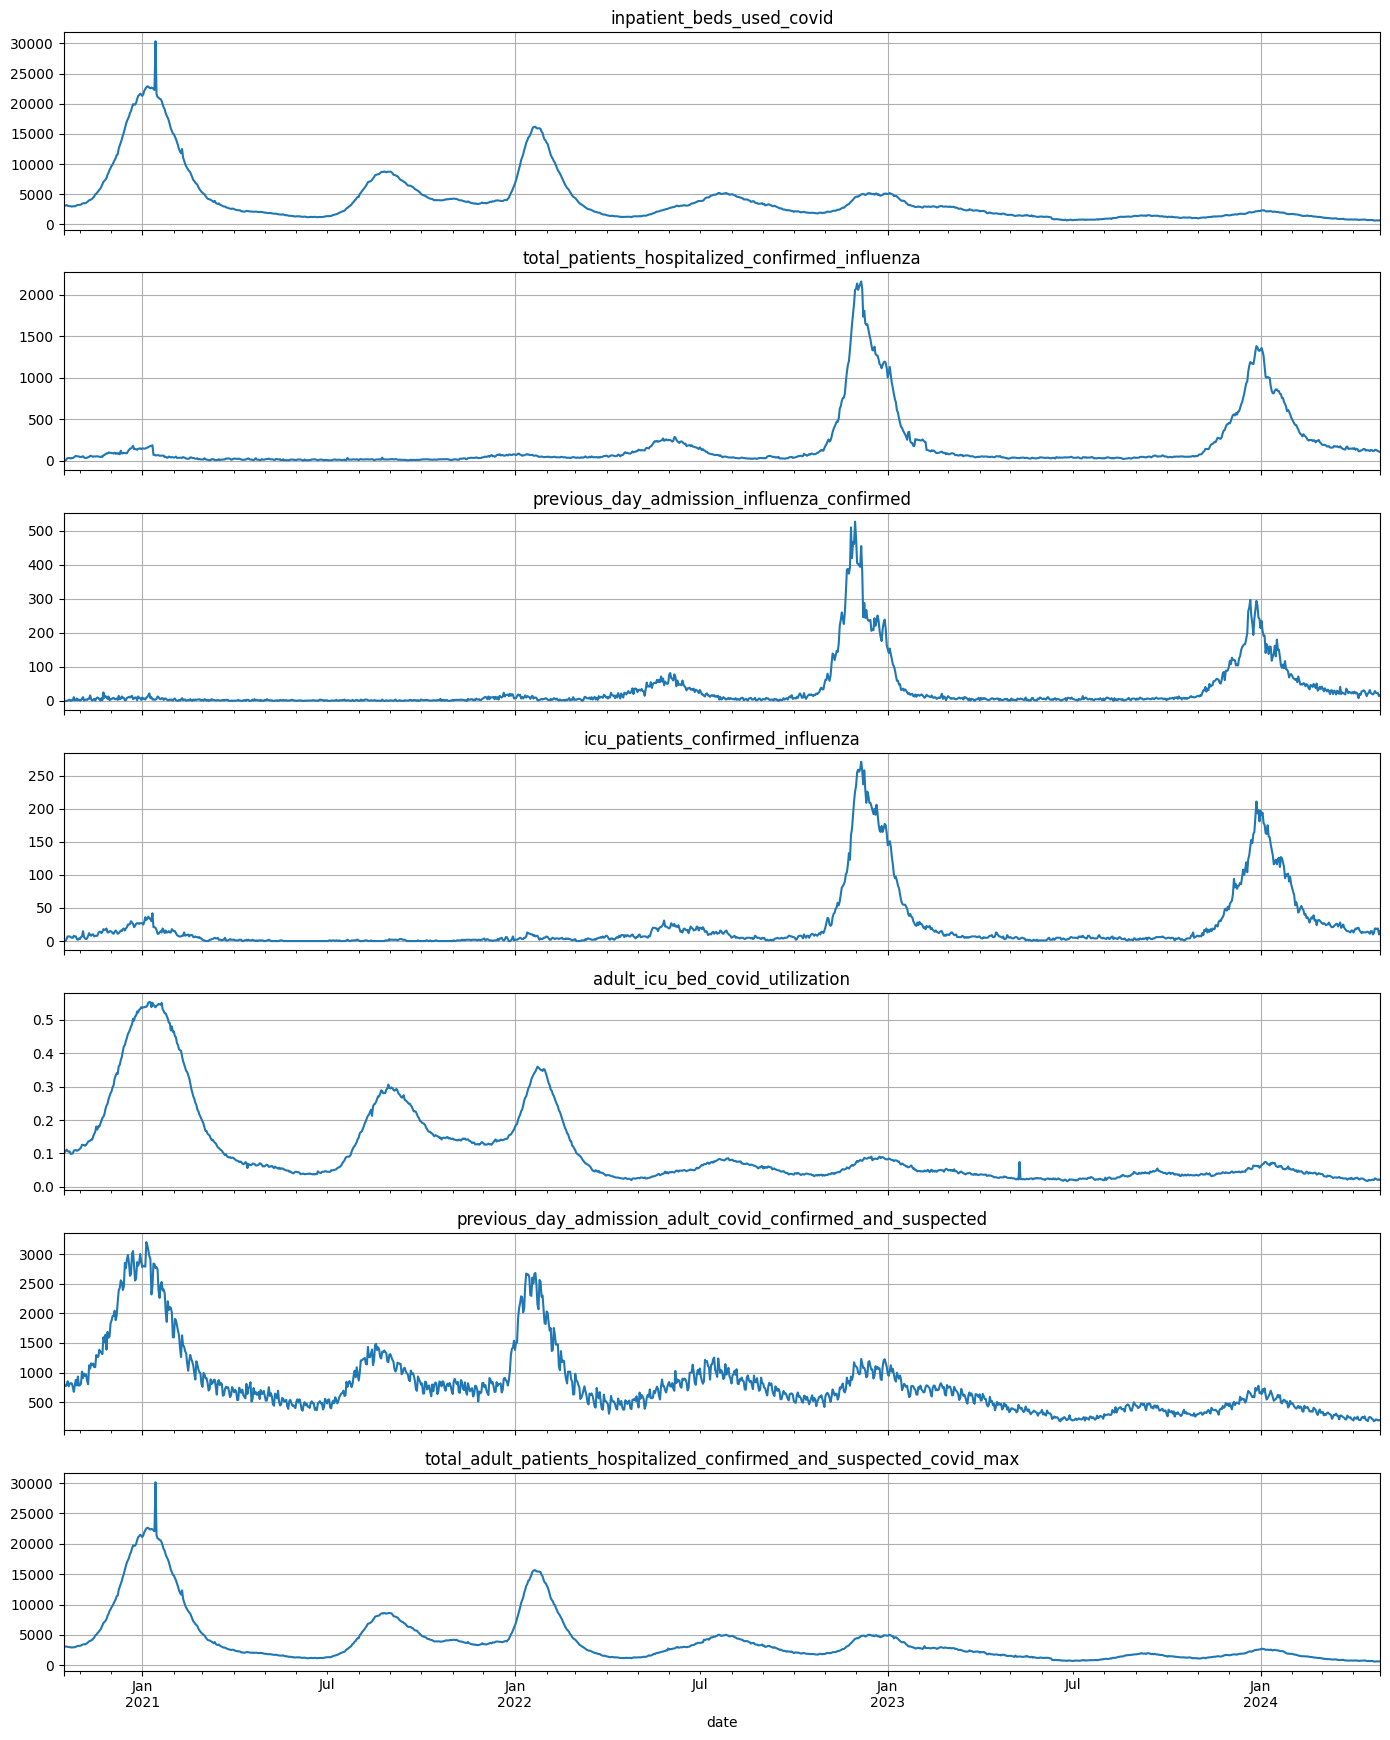

In [52]:
n = len(hhs_cleaned.columns)
fig, axes = plt.subplots(n, 1, figsize=(14, 2.5 * n), sharex=True)

for ax, col in zip(axes, hhs_cleaned.columns):
    hhs_cleaned[col].plot(ax=ax)
    ax.set_title(col)
    ax.grid(True)

plt.tight_layout()
plt.show()

## Validating pipeline flow(COVID)

My assumption is that there is a temporal ordering for COVID features retained(admissions -> hospitalizations -> ICU)

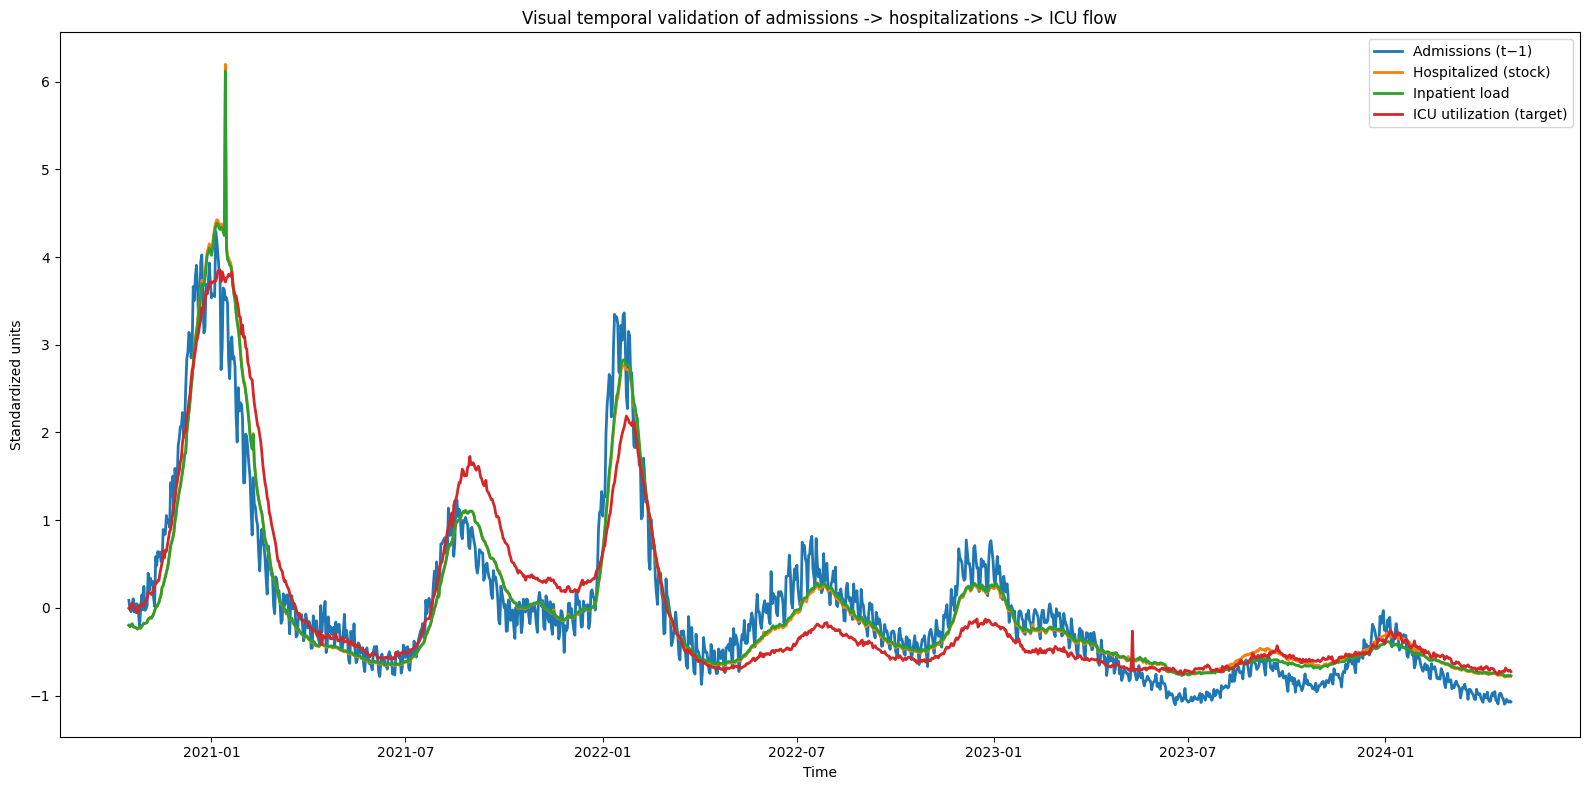

In [53]:
cols = [
    'previous_day_admission_adult_covid_confirmed_and_suspected',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid_max',
    'inpatient_beds_used_covid',
    'adult_icu_bed_covid_utilization'
]

scaled = StandardScaler().fit_transform(hhs_cleaned[cols])
scaled_df = pd.DataFrame(scaled, columns=cols, index=hhs_cleaned.index)

plt.figure(figsize=(16, 8))

plt.plot(scaled_df['previous_day_admission_adult_covid_confirmed_and_suspected'], label='Admissions (t−1)', linewidth=2)
plt.plot(scaled_df['total_adult_patients_hospitalized_confirmed_and_suspected_covid_max'], label='Hospitalized (stock)', linewidth=2)
plt.plot(scaled_df['inpatient_beds_used_covid'], label='Inpatient load', linewidth=2)
plt.plot(scaled_df['adult_icu_bed_covid_utilization'], label='ICU utilization (target)', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Standardized units")
plt.title("Visual temporal validation of admissions -> hospitalizations -> ICU flow")
plt.legend()
plt.tight_layout()
plt.show()


Standardized time-series overlays confirm the assumed temporal ordering of hospital stress dynamics: COVID admissions lead hospital census, which drives inpatient load and subsequently ICU utilization. This lead–lag structure is stable across multiple pandemic waves, supporting the causal feature pipeline used for modeling and justifying the use of upstream demand indicators to anticipate ICU stress.

## Save cleaned dataset

In [54]:
# Ensure data directory exists
# Path to data directory (parent of notebooks/)
data_dir = Path("..") / "data"
data_dir.mkdir(exist_ok=True)

# Save cleaned dataset
hhs_cleaned.to_parquet(data_dir / "hhs_cleaned.parquet", index=True)